In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE

In [59]:
USA_df = pd.read_csv('USA_df.csv')

USA_df['Book-to-Market'] = 1 / USA_df['Book-to-Market']
USA_df['Earnings-Price'] = 1 / USA_df['Earnings-Price']

In [60]:
variables = ['EXRET', '12m_momentum', 'industry_momentum', '1m_reversal', 'MV', 'DV', 'BAS', 'annual_TRV', 'IV', 'MB', 'Book-to-Market', 'Earnings-Price', 'Sales-to-Price', 'tbl', 'T10Y3MM', 'gpce']
overall_stats = USA_df[variables].describe().transpose()
overall_stats['variance'] = USA_df[variables].var()
overall_stats = overall_stats[['mean', '50%', 'std', 'variance', 'min', 'max']]
overall_stats.columns = ['Mean', 'Median', 'Std Deviation', 'Variance', 'Min', 'Max']

print(overall_stats)

                           Mean        Median  Std Deviation      Variance  \
EXRET             -1.659455e-03 -9.865000e-04   8.982433e-02  8.068410e-03   
12m_momentum       1.639192e-01  1.313685e-01   4.069591e-01  1.656157e-01   
industry_momentum  1.664594e-01  1.483885e-01   2.631745e-01  6.926084e-02   
1m_reversal        1.226747e-02  1.265800e-02   8.770417e-02  7.692022e-03   
MV                 4.464746e+07  1.733588e+07   1.120361e+08  1.255209e+16   
DV                 6.168596e+09  2.842522e+09   1.587336e+10  2.519636e+20   
BAS                4.381672e-02  1.650000e-02   2.198831e-01  4.834858e-02   
annual_TRV         1.764457e-02  1.536651e-02   8.610817e-03  7.414616e-05   
IV                 1.618705e-02  1.506175e-02   5.171155e-03  2.674085e-05   
MB                 1.027397e+00  1.038353e+00   2.889943e-01  8.351768e-02   
Book-to-Market     3.782028e+00  3.034073e+00   2.127858e+01  4.527779e+02   
Earnings-Price     2.576527e+01  2.199699e+01   1.336266e+02  1.

In [61]:
variables = ['EXRET', '12m_momentum', 'industry_momentum', '1m_reversal', 'MV', 'DV', 'BAS', 'annual_TRV', 'IV', 'MB', 'Book-to-Market', 'Earnings-Price', 'Sales-to-Price', 'tbl', 'T10Y3MM', 'gpce']

def descriptive_stats(group):
    desc = group[variables].describe().transpose()
    desc['variance'] = group[variables].var()
    return desc

grouped = USA_df.groupby('TICKER').apply(descriptive_stats)
within_entity_stats = grouped.groupby(level=1).mean()
within_entity_stats = within_entity_stats[['mean', '50%', 'std', 'variance', 'min', 'max']]
within_entity_stats.columns = ['Mean', 'Median', 'Std Deviation', 'Variance', 'Min', 'Max']

print(within_entity_stats)

                           Mean        Median  Std Deviation      Variance  \
12m_momentum       1.639192e-01  1.327384e-01   3.530771e-01  1.592795e-01   
1m_reversal        1.226747e-02  1.291163e-02   8.279515e-02  7.701756e-03   
BAS                4.381672e-02  2.732134e-02   4.381283e-02  2.178735e-02   
Book-to-Market     3.782028e+00  3.538308e+00   4.835165e+00  4.053790e+02   
DV                 6.168596e+09  5.006959e+09   4.016878e+09  1.250805e+20   
EXRET             -1.659455e-03 -5.279403e-04   8.520557e-02  8.079679e-03   
Earnings-Price     2.576527e+01  2.307174e+01   3.175212e+01  1.698947e+04   
IV                 1.618705e-02  1.618705e-02   4.478770e-17  3.027189e-33   
MB                 1.027397e+00  1.027397e+00   2.933109e-15  1.229465e-29   
MV                 4.464746e+07  3.653795e+07   2.645385e+07  6.104320e+15   
Sales-to-Price     2.898644e+02  2.784721e+02   6.643483e+01  2.838886e+04   
T10Y3MM            1.460167e+00  1.585000e+00   1.240333e+00  1.

In [62]:
def create_lag_features(df, features, lags):
    for feature in features:
        for lag in lags:
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    return df

features = ['12m_momentum', 'industry_momentum', '1m_reversal', 'MV', 'DV', 'BAS', 'annual_TRV', 'IV', 'MB', 'Earnings-Price', 'Sales-to-Price']
lags = [1, 3, 6, 12]
USA_df = create_lag_features(USA_df, features, lags)
USA_df = USA_df.dropna()

In [64]:
USA_df['date'] = pd.to_datetime(USA_df['date'])
USA_df = USA_df.sort_values(by='date')

X = USA_df.drop(columns=['date', 'EXRET', 'PERMNO', 'TICKER', 'PRC', 'SHROUT', 
                         'VOL', 'RET', 'SICCD', 'COMNAM', 'NAICS', 'year', 'ntis'])
y = USA_df['EXRET']

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

train_size = int(len(USA_df) * 0.6)
val_size = int(len(USA_df) * 0.2)
test_size = len(USA_df) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training Set Size: {train_size}")
print(f"Validation Set Size: {val_size}")
print(f"Test Set Size: {test_size}")

print(f"Training from {USA_df['date'].iloc[0]} to {USA_df['date'].iloc[train_size-1]}")
print(f"Validate from {USA_df['date'].iloc[train_size]} to {USA_df['date'].iloc[train_size+val_size-1]}")
print(f"Test from {USA_df['date'].iloc[train_size+val_size]} to {USA_df['date'].iloc[-1]}")

Training Set Size: 42184
Validation Set Size: 14061
Test Set Size: 14063
Training from 2004-01-01 00:00:00 to 2016-01-01 00:00:00
Validate from 2016-01-01 00:00:00 to 2020-01-01 00:00:00
Test from 2020-01-01 00:00:00 to 2023-12-01 00:00:00


In [46]:
def calculate_oos_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum(y_true ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_sharpe_ratio(y_pred):
    return np.mean(y_pred) / np.std(y_pred)

# OLS

In [47]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
y_pred_val_ols = ols.predict(X_val_scaled)

mse_val_ols = mean_squared_error(y_val, y_pred_val_ols)
r2_val_ols = r2_score(y_val, y_pred_val_ols)
oos_r2_val_ols = calculate_oos_r2(y_val, y_pred_val_ols)
sharpe_ratio_val_ols = calculate_sharpe_ratio(y_pred_val_ols)

print(f"\nOLS (Validation) - MSE: {mse_val_ols}, R^2: {r2_val_ols}, Out-of-sample R^2: {oos_r2_val_ols}, Sharpe Ratio: {sharpe_ratio_val_ols}")


OLS (Validation) - MSE: 0.005100917297174723, R^2: 0.03832066278454549, Out-of-sample R^2: 0.03852641899513842, Sharpe Ratio: 0.15464772614443023


In [48]:
y_pred_test_ols = ols.predict(X_test_scaled)

mse_test_ols = mean_squared_error(y_test, y_pred_test_ols)
r2_test_ols = r2_score(y_test, y_pred_test_ols)
oos_r2_test_ols = calculate_oos_r2(y_test, y_pred_test_ols)
sharpe_ratio_test_ols = calculate_sharpe_ratio(y_pred_test_ols)

print(f"\nOLS (Test) - MSE: {mse_test_ols}, R^2: {r2_test_ols}, Out-of-sample R^2: {oos_r2_test_ols}, Sharpe Ratio: {sharpe_ratio_test_ols}")


OLS (Test) - MSE: 0.009684423715724965, R^2: 0.05204388171978791, Out-of-sample R^2: 0.056407743258957144, Sharpe Ratio: 0.01975732318888959


# Elastic Net

In [8]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_grid_en = {'alpha': [0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
grid_search_en = GridSearchCV(ElasticNet(), param_grid_en, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_en.fit(X_train_selected, y_train)

best_en = grid_search_en.best_estimator_
y_pred_val_en = best_en.predict(X_val_selected)

mse_val_en = mean_squared_error(y_val, y_pred_val_en)
r2_val_en = r2_score(y_val, y_pred_val_en)
oos_r2_val_en = calculate_oos_r2(y_val, y_pred_val_en)
sharpe_ratio_val_en = calculate_sharpe_ratio(y_pred_val_en)

print(f"\nElastic Net (Validation) - MSE: {mse_val_en}, R^2: {r2_val_en}, Out-of-sample R^2: {oos_r2_val_en}, Sharpe Ratio: {sharpe_ratio_val_en}")


Elastic Net (Validation) - MSE: 0.005245131468365576, R^2: 0.011131868987651172, Out-of-sample R^2: 0.011343442379674218, Sharpe Ratio: -0.268632543496429


# PCA

In [9]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

n_components_range = [i for i in [5, 10, 15] if i <= min(X_train_selected.shape[0], X_train_selected.shape[1])]
if not n_components_range:
    n_components_range = [min(X_train_selected.shape[0], X_train_selected.shape[1])]

print(f"n_components_range: {n_components_range}")

pipeline_pcr = Pipeline([('pca', PCA()), ('linear_regression', LinearRegression())])
param_grid_pcr = {'pca__n_components': n_components_range}
grid_search_pcr = GridSearchCV(pipeline_pcr, param_grid_pcr, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_pcr.fit(X_train_selected, y_train)

best_pcr = grid_search_pcr.best_estimator_
y_pred_val_pcr = best_pcr.predict(X_val_selected)

mse_val_pcr = mean_squared_error(y_val, y_pred_val_pcr)
r2_val_pcr = r2_score(y_val, y_pred_val_pcr)
oos_r2_val_pcr = calculate_oos_r2(y_val, y_pred_val_pcr)
sharpe_ratio_val_pcr = calculate_sharpe_ratio(y_pred_val_pcr)

print(f"\nPrincipal Component Regression (Validation) - MSE: {mse_val_pcr}, R^2: {r2_val_pcr}, Out-of-sample R^2: {oos_r2_val_pcr}, Sharpe Ratio: {sharpe_ratio_val_pcr}")

n_components_range: [5, 10]

Principal Component Regression (Validation) - MSE: 0.005328140308887145, R^2: -0.004517843031797142, Out-of-sample R^2: -0.004302921303881435, Sharpe Ratio: -0.22276086372866868


# Random Forest

In [10]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3]
}

random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf, n_iter=10, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train_selected, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_val_rf = best_rf.predict(X_val_selected)

mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
r2_val_rf = r2_score(y_val, y_pred_val_rf)
oos_r2_val_rf = calculate_oos_r2(y_val, y_pred_val_rf)
sharpe_ratio_val_rf = calculate_sharpe_ratio(y_pred_val_rf)

print(f"\nRandom Forest (Validation) - MSE: {mse_val_rf}, R^2: {r2_val_rf}, Out-of-sample R^2: {oos_r2_val_rf}, Sharpe Ratio: {sharpe_ratio_val_rf}")


Random Forest (Validation) - MSE: 0.009402239062419436, R^2: -0.7726103959569968, Out-of-sample R^2: -0.7722311369006611, Sharpe Ratio: -1.0751093530328157


# Gradient Boosting

In [11]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

random_search_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist_gb, n_iter=8, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_gb.fit(X_train_selected, y_train)

best_gb = random_search_gb.best_estimator_
y_pred_val_gb = best_gb.predict(X_val_selected)

mse_val_gb = mean_squared_error(y_val, y_pred_val_gb)
r2_val_gb = r2_score(y_val, y_pred_val_gb)
oos_r2_val_gb = calculate_oos_r2(y_val, y_pred_val_gb)
sharpe_ratio_val_gb = calculate_sharpe_ratio(y_pred_val_gb)

print(f"\nGradient Boosting (Validation) - MSE: {mse_val_gb}, R^2: {r2_val_gb}, Out-of-sample R^2: {oos_r2_val_gb}, Sharpe Ratio: {sharpe_ratio_val_gb}")


Gradient Boosting (Validation) - MSE: 0.006394036681212304, R^2: -0.2054719964045184, Out-of-sample R^2: -0.20521407950815007, Sharpe Ratio: -1.461786553744211


# Neural Network

In [49]:
random_seed = 42

lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_nn = {
    'hidden_layer_sizes': [(50,), (50, 50), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'solver': ['adam', 'sgd', 'adamw'],
    'batch_size': [32, 64, 128]
}

random_search_nn = RandomizedSearchCV(MLPRegressor(max_iter=5000, early_stopping=True, random_state=42), 
                                      param_distributions=param_dist_nn, 
                                      n_iter=20, 
                                      cv=TimeSeriesSplit(n_splits=5), 
                                      scoring='neg_mean_squared_error', 
                                      n_jobs=-1, 
                                      random_state=42)
random_search_nn.fit(X_train_selected, y_train)

best_nn = random_search_nn.best_estimator_
y_pred_val_nn = best_nn.predict(X_val_selected)

mse_val_nn = mean_squared_error(y_val, y_pred_val_nn)
r2_val_nn = r2_score(y_val, y_pred_val_nn)
oos_r2_val_nn = calculate_oos_r2(y_val, y_pred_val_nn)
sharpe_ratio_val_nn = calculate_sharpe_ratio(y_pred_val_nn)

print(f"\nNeural Network (Validation) - MSE: {mse_val_nn}, R^2: {r2_val_nn}, Out-of-sample R^2: {oos_r2_val_nn}, Sharpe Ratio: {sharpe_ratio_val_nn}")

/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(


Neural Network (Validation) - MSE: 0.0052318050869532, R^2: 0.013644300555838318, Out-of-sample R^2: 0.013855336400283136, Sharpe Ratio: -0.12922856612329353


In [50]:
model = LinearRegression()
selector = RFE(model, n_features_to_select=10)  # 选择10个特征
selector = selector.fit(X_train_scaled, y_train)

selected_features = selector.support_

X_train_selected = X_train_scaled[:, selected_features]
X_val_selected = X_val_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

random_search_nn.fit(X_train_selected, y_train)

best_nn = random_search_nn.best_estimator_
y_pred_val_nn = best_nn.predict(X_val_selected)

mse_val_nn = mean_squared_error(y_val, y_pred_val_nn)
r2_val_nn = r2_score(y_val, y_pred_val_nn)
oos_r2_val_nn = calculate_oos_r2(y_val, y_pred_val_nn)
sharpe_ratio_val_nn = calculate_sharpe_ratio(y_pred_val_nn)

print(f"\nNeural Network (Validation) - MSE: {mse_val_nn}, R^2: {r2_val_nn}, Out-of-sample R^2: {oos_r2_val_nn}, Sharpe Ratio: {sharpe_ratio_val_nn}")# 使用线性回归模型进行递归特征消除
model = LinearRegression()
selector = RFE(model, n_features_to_select=10) 
selector = selector.fit(X_train_scaled, y_train)

selected_features = selector.support_

X_train_selected = X_train_scaled[:, selected_features]
X_val_selected = X_val_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

random_search_nn.fit(X_train_selected, y_train)

best_nn = random_search_nn.best_estimator_
y_pred_val_nn = best_nn.predict(X_val_selected)

mse_val_nn = mean_squared_error(y_val, y_pred_val_nn)
r2_val_nn = r2_score(y_val, y_pred_val_nn)
oos_r2_val_nn = calculate_oos_r2(y_val, y_pred_val_nn)
sharpe_ratio_val_nn = calculate_sharpe_ratio(y_pred_val_nn)

print(f"\nNeural Network (Validation) - MSE: {mse_val_nn}, R^2: {r2_val_nn}, Out-of-sample R^2: {oos_r2_val_nn}, Sharpe Ratio: {sharpe_ratio_val_nn}")

/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(


Neural Network (Validation) - MSE: 0.0009264808141670491, R^2: 0.8253299547113823, Out-of-sample R^2: 0.8253673262605379, Sharpe Ratio: 0.003644017174272767


/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(


Neural Network (Validation) - MSE: 0.0009264808141670491, R^2: 0.8253299547113823, Out-of-sample R^2: 0.8253673262605379, Sharpe Ratio: 0.003644017174272767


In [51]:
y_pred_test_nn = best_nn.predict(X_test_selected)

print("\nNeural Network (Test) - Predictions:")
print(y_pred_test_nn)

mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)
oos_r2_test_nn = calculate_oos_r2(y_test, y_pred_test_nn)
sharpe_ratio_test_nn = calculate_sharpe_ratio(y_pred_test_nn)

print(f"\nNeural Network (Test) - MSE: {mse_test_nn}, R^2: {r2_test_nn}, Out-of-sample R^2: {oos_r2_test_nn}, Sharpe Ratio: {sharpe_ratio_test_nn}")


Neural Network (Test) - Predictions:
[-0.1273691  -0.07366435 -0.11914568 ... -0.04544413  0.03134443
  0.07556302]

Neural Network (Test) - MSE: 0.0024119907366923956, R^2: 0.7639032075424231, Out-of-sample R^2: 0.7649900655649189, Sharpe Ratio: -0.08142592772764444


# Neural Network Analysis

## volatility

In [52]:
volatility = np.std(y_pred_test_nn)
print(f'Volatility: {volatility}')

Volatility: 0.08736565559841913


## Cumulative Return

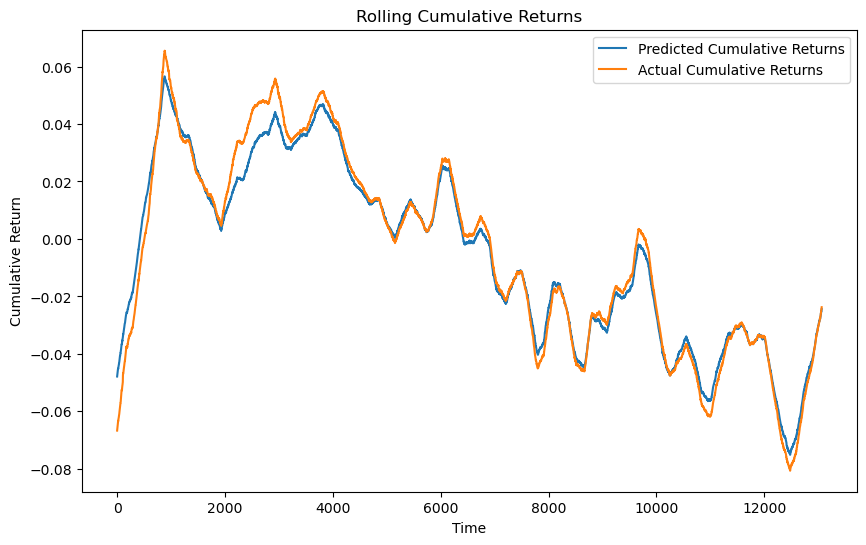

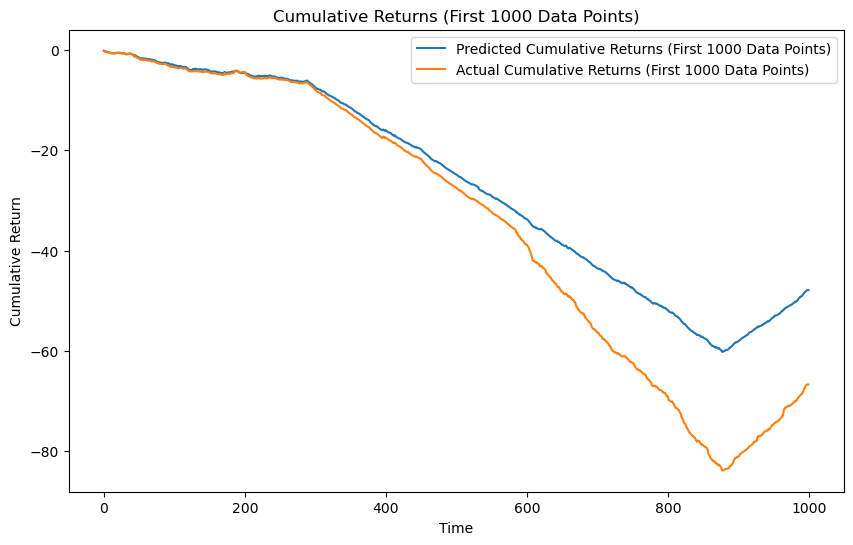

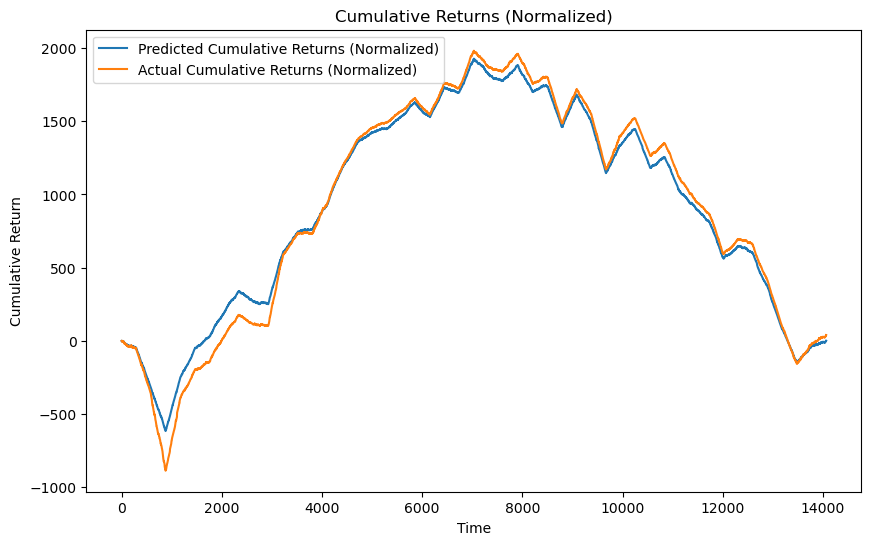

In [17]:
y_pred_test_nn = np.array(y_pred_test_nn) 
y_test = np.array(y_test)

window_size = 1000  
rolling_returns_pred = np.convolve(y_pred_test_nn, np.ones(window_size), 'valid') / window_size
rolling_returns_actual = np.convolve(y_test, np.ones(window_size), 'valid') / window_size

plt.figure(figsize=(10, 6))
plt.plot(rolling_returns_pred, label='Predicted Cumulative Returns')
plt.plot(rolling_returns_actual, label='Actual Cumulative Returns')
plt.legend()
plt.title('Rolling Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(y_pred_test_nn[:1000]), label='Predicted Cumulative Returns (First 1000 Data Points)')
plt.plot(np.cumsum(y_test[:1000]), label='Actual Cumulative Returns (First 1000 Data Points)')
plt.legend()
plt.title('Cumulative Returns (First 1000 Data Points)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

scaler = StandardScaler()
y_pred_test_nn_scaled = scaler.fit_transform(y_pred_test_nn.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(y_pred_test_nn_scaled), label='Predicted Cumulative Returns (Normalized)')
plt.plot(np.cumsum(y_test_scaled), label='Actual Cumulative Returns (Normalized)')
plt.legend()
plt.title('Cumulative Returns (Normalized)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

## Annualized Return

In [18]:
# 计算年化回报
num_periods = len(y_pred_test_nn)
annualized_return_pred = (1 + np.mean(y_pred_test_nn)) ** 12 - 1  
annualized_return_actual = (1 + np.mean(y_test)) ** 12 - 1

print(f'Predicted Annualized Return: {annualized_return_pred}')
print(f'Actual Annualized Return: {annualized_return_actual}')

Predicted Annualized Return: -0.08210386905564215
Actual Annualized Return: -0.07943561152493528


## Feature Importance

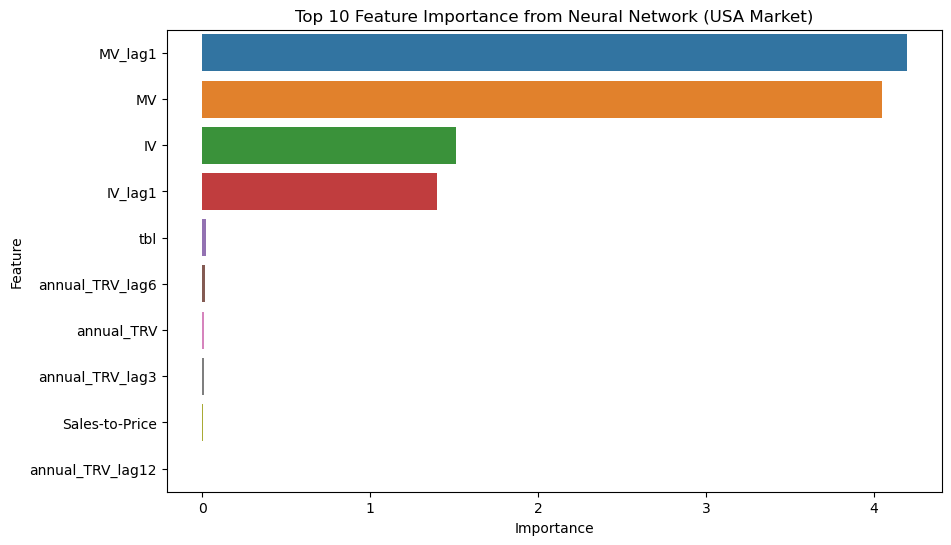

In [19]:
perm_importance = permutation_importance(best_nn, X_val_selected, y_val, n_repeats=10, random_state=random_seed)
feature_names = X.columns[selector.get_support()]

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Feature Importance from Neural Network (USA Market)')
plt.show()

## Cumulative Return2

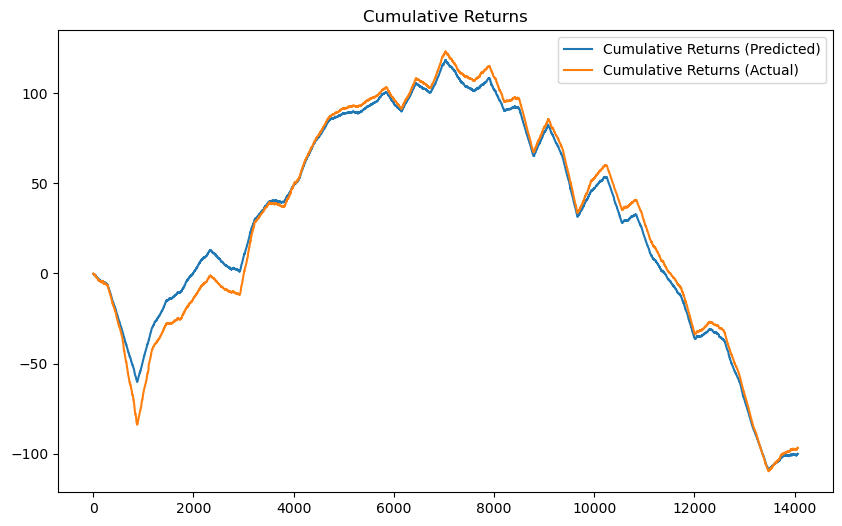

In [20]:
cumulative_returns = np.cumsum(y_pred_test_nn)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Cumulative Returns (Predicted)')
plt.plot(np.cumsum(y_test), label='Cumulative Returns (Actual)')
plt.legend()
plt.title('Cumulative Returns')
plt.show()

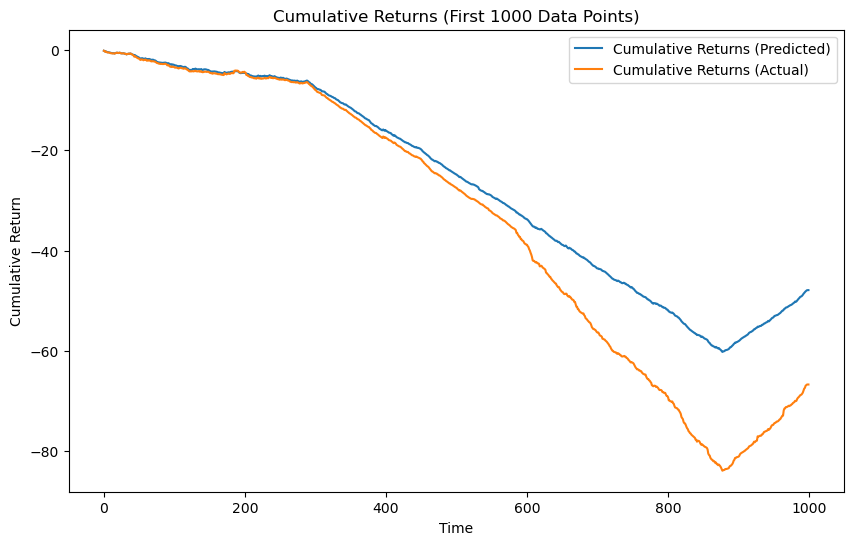

In [21]:
cumulative_returns_pred = np.cumsum(y_pred_test_nn[:1000])
cumulative_returns_actual = np.cumsum(y_test[:1000])

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_pred, label='Cumulative Returns (Predicted)')
plt.plot(cumulative_returns_actual, label='Cumulative Returns (Actual)')
plt.legend()
plt.title('Cumulative Returns (First 1000 Data Points)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

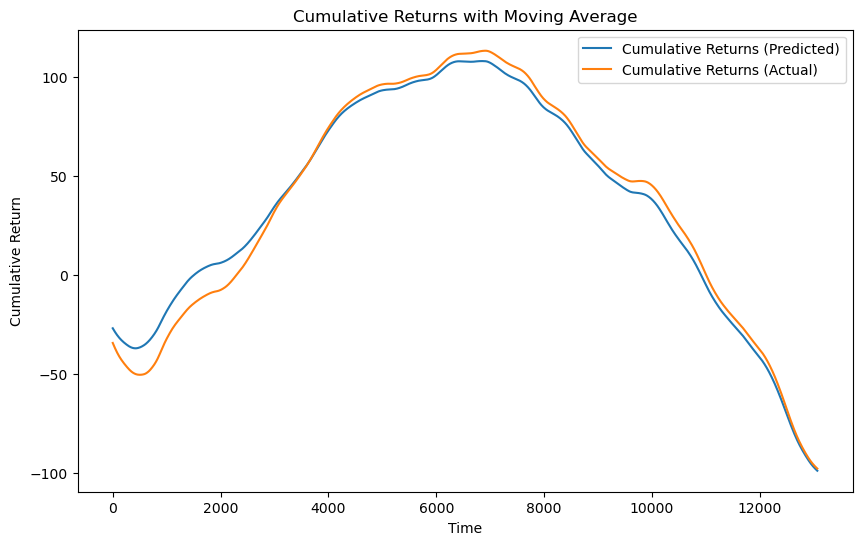

In [22]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 1000
cumulative_returns_pred = moving_average(np.cumsum(y_pred_test_nn), window_size)
cumulative_returns_actual = moving_average(np.cumsum(y_test), window_size)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_pred, label='Cumulative Returns (Predicted)')
plt.plot(cumulative_returns_actual, label='Cumulative Returns (Actual)')
plt.legend()
plt.title('Cumulative Returns with Moving Average')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

## Industry Analysis

In [23]:
USA_df_filter = USA_df.drop(columns=['date', 'PERMNO', 'TICKER', 'PRC', 'SHROUT', 
                         'VOL', 'RET', 'SICCD', 'COMNAM', 'year', 'ntis'])

In [24]:
random_seed = 42

def select_features_with_rfe(X_train, y_train, n_features=10):
    model = LinearRegression()
    selector = RFE(model, n_features_to_select=n_features)
    selector = selector.fit(X_train, y_train)
    return selector.support_

def calculate_oos_r2(y_true, y_pred):
    ss_res = sum((y_true - y_pred) ** 2)
    ss_tot = sum((y_true - y_true.mean()) ** 2)
    return 1 - ss_res / ss_tot

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def train_and_evaluate_model(industry_data, selected_features):
    if len(industry_data) < 10:  
        return None, None, None, None, None, None, None, None
    
    X = industry_data[numeric_features]
    y = industry_data['EXRET']

    train_size = int(len(X) * 0.6)
    val_size = int(len(X) * 0.2)
    test_size = len(X) - train_size - val_size

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    X_train_selected = X_train_scaled[:, selected_features]
    X_val_selected = X_val_scaled[:, selected_features]
    X_test_selected = X_test_scaled[:, selected_features]

    model = MLPRegressor(hidden_layer_sizes=(100,), random_state=random_seed, max_iter=200)
    param_distributions = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    random_search_nn = RandomizedSearchCV(model, param_distributions, n_iter=20, cv=2, random_state=random_seed, n_jobs=-1)
    random_search_nn.fit(X_train_selected, y_train)

    best_nn = random_search_nn.best_estimator_
    y_pred_val_nn = best_nn.predict(X_val_selected)
    y_pred_test_nn = best_nn.predict(X_test_selected)

    mse_val = mean_squared_error(y_val, y_pred_val_nn)
    r2_val = r2_score(y_val, y_pred_val_nn)
    oos_r2_val = calculate_oos_r2(y_val, y_pred_val_nn)
    sharpe_ratio_val = calculate_sharpe_ratio(y_pred_val_nn)

    mse_test = mean_squared_error(y_test, y_pred_test_nn)
    r2_test = r2_score(y_test, y_pred_test_nn)
    oos_r2_test = calculate_oos_r2(y_test, y_pred_test_nn)
    sharpe_ratio_test = calculate_sharpe_ratio(y_pred_test_nn)

    return mse_val, r2_val, oos_r2_val, sharpe_ratio_val, mse_test, r2_test, oos_r2_test, sharpe_ratio_test

numeric_features = USA_df_filter.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('EXRET') 

industries = USA_df_filter['NAICS'].unique()
industry_results = []

X = USA_df_filter[numeric_features]
y = USA_df_filter['EXRET']

train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

selected_features = select_features_with_rfe(X_train_scaled, y_train)

for industry in industries:
    industry_data = USA_df[USA_df_filter['NAICS'] == industry]
    results = train_and_evaluate_model(industry_data, selected_features)
    if results[0] is not None: 
        mse_val, r2_val, oos_r2_val, sharpe_ratio_val, mse_test, r2_test, oos_r2_test, sharpe_ratio_test = results
        industry_results.append({
            'Industry': industry,
            'Validation MSE': mse_val,
            'Validation R2': r2_val,
            'Out-of-sample Validation R2': oos_r2_val,
            'Validation Sharpe Ratio': sharpe_ratio_val,
            'Test MSE': mse_test,
            'Test R2': r2_test,
            'Out-of-sample Test R2': oos_r2_test,
            'Test Sharpe Ratio': sharpe_ratio_test
        })

industry_results_df = pd.DataFrame(industry_results)
industry_results_df = industry_results_df.sort_values(by='Out-of-sample Test R2', ascending=False)

print(industry_results_df)

     Industry  Validation MSE  Validation R2  Out-of-sample Validation R2  \
23   336111.0        0.001150       0.736154                     0.736154   
99   551112.0        0.001154       0.656839                     0.656839   
64   524113.0        0.001292       0.780471                     0.780471   
7    335921.0        0.001285       0.719096                     0.719096   
93   522210.0        0.000816       0.767185                     0.767185   
..        ...             ...            ...                          ...   
15   621511.0        0.129494     -46.492500                   -46.492500   
114  325620.0        0.091732     -30.893122                   -30.893122   
97   621491.0        0.047419      -2.608406                    -2.608406   
123  322222.0        0.016350      -3.004339                    -3.004339   
46   531312.0        0.041638      -6.770950                    -6.770950   

     Validation Sharpe Ratio  Test MSE     Test R2  Out-of-sample Test R2  

In [25]:
top5_industries = industry_results_df.head(5)
print(top5_industries)

    Industry  Validation MSE  Validation R2  Out-of-sample Validation R2  \
23  336111.0        0.001150       0.736154                     0.736154   
99  551112.0        0.001154       0.656839                     0.656839   
64  524113.0        0.001292       0.780471                     0.780471   
7   335921.0        0.001285       0.719096                     0.719096   
93  522210.0        0.000816       0.767185                     0.767185   

    Validation Sharpe Ratio  Test MSE   Test R2  Out-of-sample Test R2  \
23                -0.330976  0.005100  0.751381               0.751381   
99                -0.062938  0.003043  0.736530               0.736530   
64                -0.112162  0.002818  0.714744               0.714744   
7                  0.264249  0.002761  0.669363               0.669363   
93                 0.216657  0.004721  0.506453               0.506453   

    Test Sharpe Ratio  
23           0.383323  
99           0.159692  
64          -0.226438  
7 

# SVM

In [33]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_svm = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'rbf']
}

random_search_svm = RandomizedSearchCV(SVR(), param_distributions=param_dist_svm, n_iter=6, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error', n_jobs=1, random_state=42)
random_search_svm.fit(X_train_selected, y_train)

best_svm = random_search_svm.best_estimator_
y_pred_val_svm = best_svm.predict(X_val_selected)

mse_val_svm = mean_squared_error(y_val, y_pred_val_svm)
r2_val_svm = r2_score(y_val, y_pred_val_svm)
oos_r2_val_svm = calculate_oos_r2(y_val, y_pred_val_svm)
sharpe_ratio_val_svm = calculate_sharpe_ratio(y_pred_val_svm)

print(f"\nSVM (Validation) - MSE: {mse_val_svm}, R^2: {r2_val_svm}, Out-of-sample R^2: {oos_r2_val_svm}, Sharpe Ratio: {sharpe_ratio_val_svm}")



SVM (Validation) - MSE: 0.005197658375994978, R^2: 0.020082002727676906, Out-of-sample R^2: 0.020291661192830546, Sharpe Ratio: -0.16947235263665808


# KNN

In [32]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_grid_knn = {
    'n_neighbors': [5, 10, 20],
    'weights': ['uniform', 'distance']
}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train_selected, y_train)

best_knn = grid_search_knn.best_estimator_
y_pred_val_knn = best_knn.predict(X_val_selected)

mse_val_knn = mean_squared_error(y_val, y_pred_val_knn)
r2_val_knn = r2_score(y_val, y_pred_val_knn)
oos_r2_val_knn = calculate_oos_r2(y_val, y_pred_val_knn)
sharpe_ratio_val_knn = calculate_sharpe_ratio(y_pred_val_knn)

print(f"\nKNN (Validation) - MSE: {mse_val_knn}, R^2: {r2_val_knn}, Out-of-sample R^2: {oos_r2_val_knn}, Sharpe Ratio: {sharpe_ratio_val_knn}")


KNN (Validation) - MSE: 0.005409755329543938, R^2: -0.019904777263316964, Out-of-sample R^2: -0.019686563422159686, Sharpe Ratio: 0.10242819312243294


# XGB

In [31]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid_xgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train_selected, y_train)

best_xgb = grid_search_xgb.best_estimator_
y_pred_val_xgb = best_xgb.predict(X_val_selected)

mse_val_xgb = mean_squared_error(y_val, y_pred_val_xgb)
r2_val_xgb = r2_score(y_val, y_pred_val_xgb)
oos_r2_val_xgb = calculate_oos_r2(y_val, y_pred_val_xgb)
sharpe_ratio_val_xgb = calculate_sharpe_ratio(y_pred_val_xgb)

print(f"\nXGBoost (Validation) - MSE: {mse_val_xgb}, R^2: {r2_val_xgb}, Out-of-sample R^2: {oos_r2_val_xgb}, Sharpe Ratio: {sharpe_ratio_val_xgb}")


XGBoost (Validation) - MSE: 0.006332928435616977, R^2: -0.19395121814076122, Out-of-sample R^2: -0.19369576617380035, Sharpe Ratio: -1.372631311416626
